In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict,  cross_val_score

In [2]:
#importing MNIST dataset with handwritten digits 

# from sklearn.datasets import fetch_openml
# df = fetch_openml("mnist_784", version=1)

# downloading mnist data every time is ineffective, saving them once as a file then reading them is much faster

# with open("data.pickle", "wb") as f:
#     pickle.dump(df, f)

In [3]:
#load data
with open("data.pickle", "rb") as f:
    df = pickle.load(f)

In [4]:
#dividing dataset into data and target datasets
X, y = np.array(df["data"]), np.array(df["target"])
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
#y data are str type, let's transform it
print(type(y[0]))
y = y.astype("uint8")
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


In [8]:
#distribution of the number of digits in a data set
for number in range(10):
    print(f"{number}: {len(y[y==number])/len(y) * 100: .3f}%")
#it seems that dataset is not very skewed, that's good :)

0:  9.861%
1:  11.253%
2:  9.986%
3:  10.201%
4:  9.749%
5:  9.019%
6:  9.823%
7:  10.419%
8:  9.750%
9:  9.940%


In [9]:
#checking if there are nan values
print(np.isnan(X).sum())
print(np.isnan(y).sum())

0
0


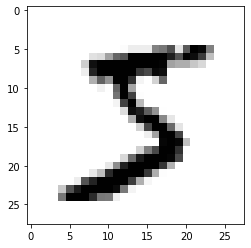

In [10]:
#showing sample image of number
plt.imshow(X[0].reshape(28,28), cmap = "binary")
plt.show()

In [11]:
#splitting datasets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1/7, random_state=42)

## model

In [13]:
#at first it would be a good idea to find the most promising model
knn_clf = KNeighborsClassifier()
sgd_clf = SGDClassifier()
rfg_clf = RandomForestClassifier()

print("knn model accuracy:", cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy"))
print("sgd model accuracy:", cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
print("rfg model accuracy:", cross_val_score(rfg_clf, X_train, y_train, cv=3, scoring="accuracy"))

knn model accuracy: [0.9673  0.96945 0.96735]
sgd model accuracy: [0.8614  0.88205 0.8757 ]
rfg model accuracy: [0.9658  0.96815 0.96545]


In [12]:
#the knn model seems to be the most promising, let's tune the hyperparameters
#building pipeline 
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", KNeighborsClassifier()),
])

params= {}
# params["scaler"] = [Normalizer(), StandardScaler(), MinMaxScaler()] 
params["scaler"] = [Normalizer()] 
params["classifier"] = [KNeighborsClassifier()]
params["classifier__n_neighbors"] = [3, 5, 7]

print(params)


grid = GridSearchCV(pipeline, params, cv=3, scoring = "accuracy", n_jobs=-1)

{'scaler': [Normalizer()], 'classifier': [KNeighborsClassifier()], 'classifier__n_neighbors': [3, 5, 7]}


In [13]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier': [KNeighborsClassifier(n_neighbors=3)],
                         'classifier__n_neighbors': [3, 5, 7],
                         'scaler': [Normalizer()]},
             scoring='accuracy')

In [14]:
evaluation = pd.DataFrame(data=grid.cv_results_)
evaluation

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.963287,0.244737,311.222089,22.211935,KNeighborsClassifier(n_neighbors=3),3,Normalizer(),{'classifier': KNeighborsClassifier(n_neighbor...,0.97415,0.9752,0.9727,0.974017,0.001025,1
1,5.523836,2.353290,324.330310,4.107602,KNeighborsClassifier(n_neighbors=3),5,Normalizer(),{'classifier': KNeighborsClassifier(n_neighbor...,0.97330,0.9744,0.9719,0.973200,0.001023,2
2,4.222510,2.090952,243.561232,93.925578,KNeighborsClassifier(n_neighbors=3),7,Normalizer(),{'classifier': KNeighborsClassifier(n_neighbor...,0.97150,0.9723,0.9712,0.971667,0.000464,3


In [15]:
# after a long time of calculations the best hyperparameters are as follows:
print(f"best estimator: {grid.best_estimator_}")
print(f"best params: {grid.best_params_}")
print(f"best accuracy: {grid.best_score_: .3f}%")


best estimator: Pipeline(steps=[('scaler', Normalizer()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])
best params: {'classifier': KNeighborsClassifier(n_neighbors=3), 'classifier__n_neighbors': 3, 'scaler': Normalizer()}
best accuracy:  0.974%


In [23]:
# training the final model on the entire data set
model = Pipeline([
    ("scaler", Normalizer()),
    ("classifier", KNeighborsClassifier(n_neighbors=3)),
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', Normalizer()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [35]:
# applying the model to the test set and see the accuracy of final model
predictions = model.predict(X_test)
print(f"accuracy: {sum(predictions == y_test)/len(y_test): .3f}%")


accuracy:  0.977%


In [39]:
#saving model
with open("model.pickle", "wb") as f:
    pickle.dump(model, f)